In [1]:
#!for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from data_processing import dataset
from models import model
from utils import tools
from plots import plots, edge_detection_plots

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#np.set_printoptions(threshold=sys.maxsize)

2022-12-28 13:44:58.879520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-28 13:44:58.984991: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-28 13:44:59.010160: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-28 13:44:59.434648: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
config_directory = 'edge_detection_with_prior_segmentation'

config_path = os.path.join(os.getcwd(), 'configs', config_directory)
DataProcessing = dataset.DataProcessing(config_path=config_path)
Model = model.Model(config_path)
tools.parser(Model.cfg, DataProcessing.cfg)
Model.load_data(DataProcessing.cfg["NAME"])
DataProcessing.path_definitions()

2022-12-28 13:45:00.569145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 13:45:00.573029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 13:45:00.573144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 13:45:00.573671: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

# Load Dataset, Preprocess Images and Dataset

The TRAIN DS contains 952 images.
The TEST DS contains 19 images.
The IMG_ONLY DS contains 10 images.


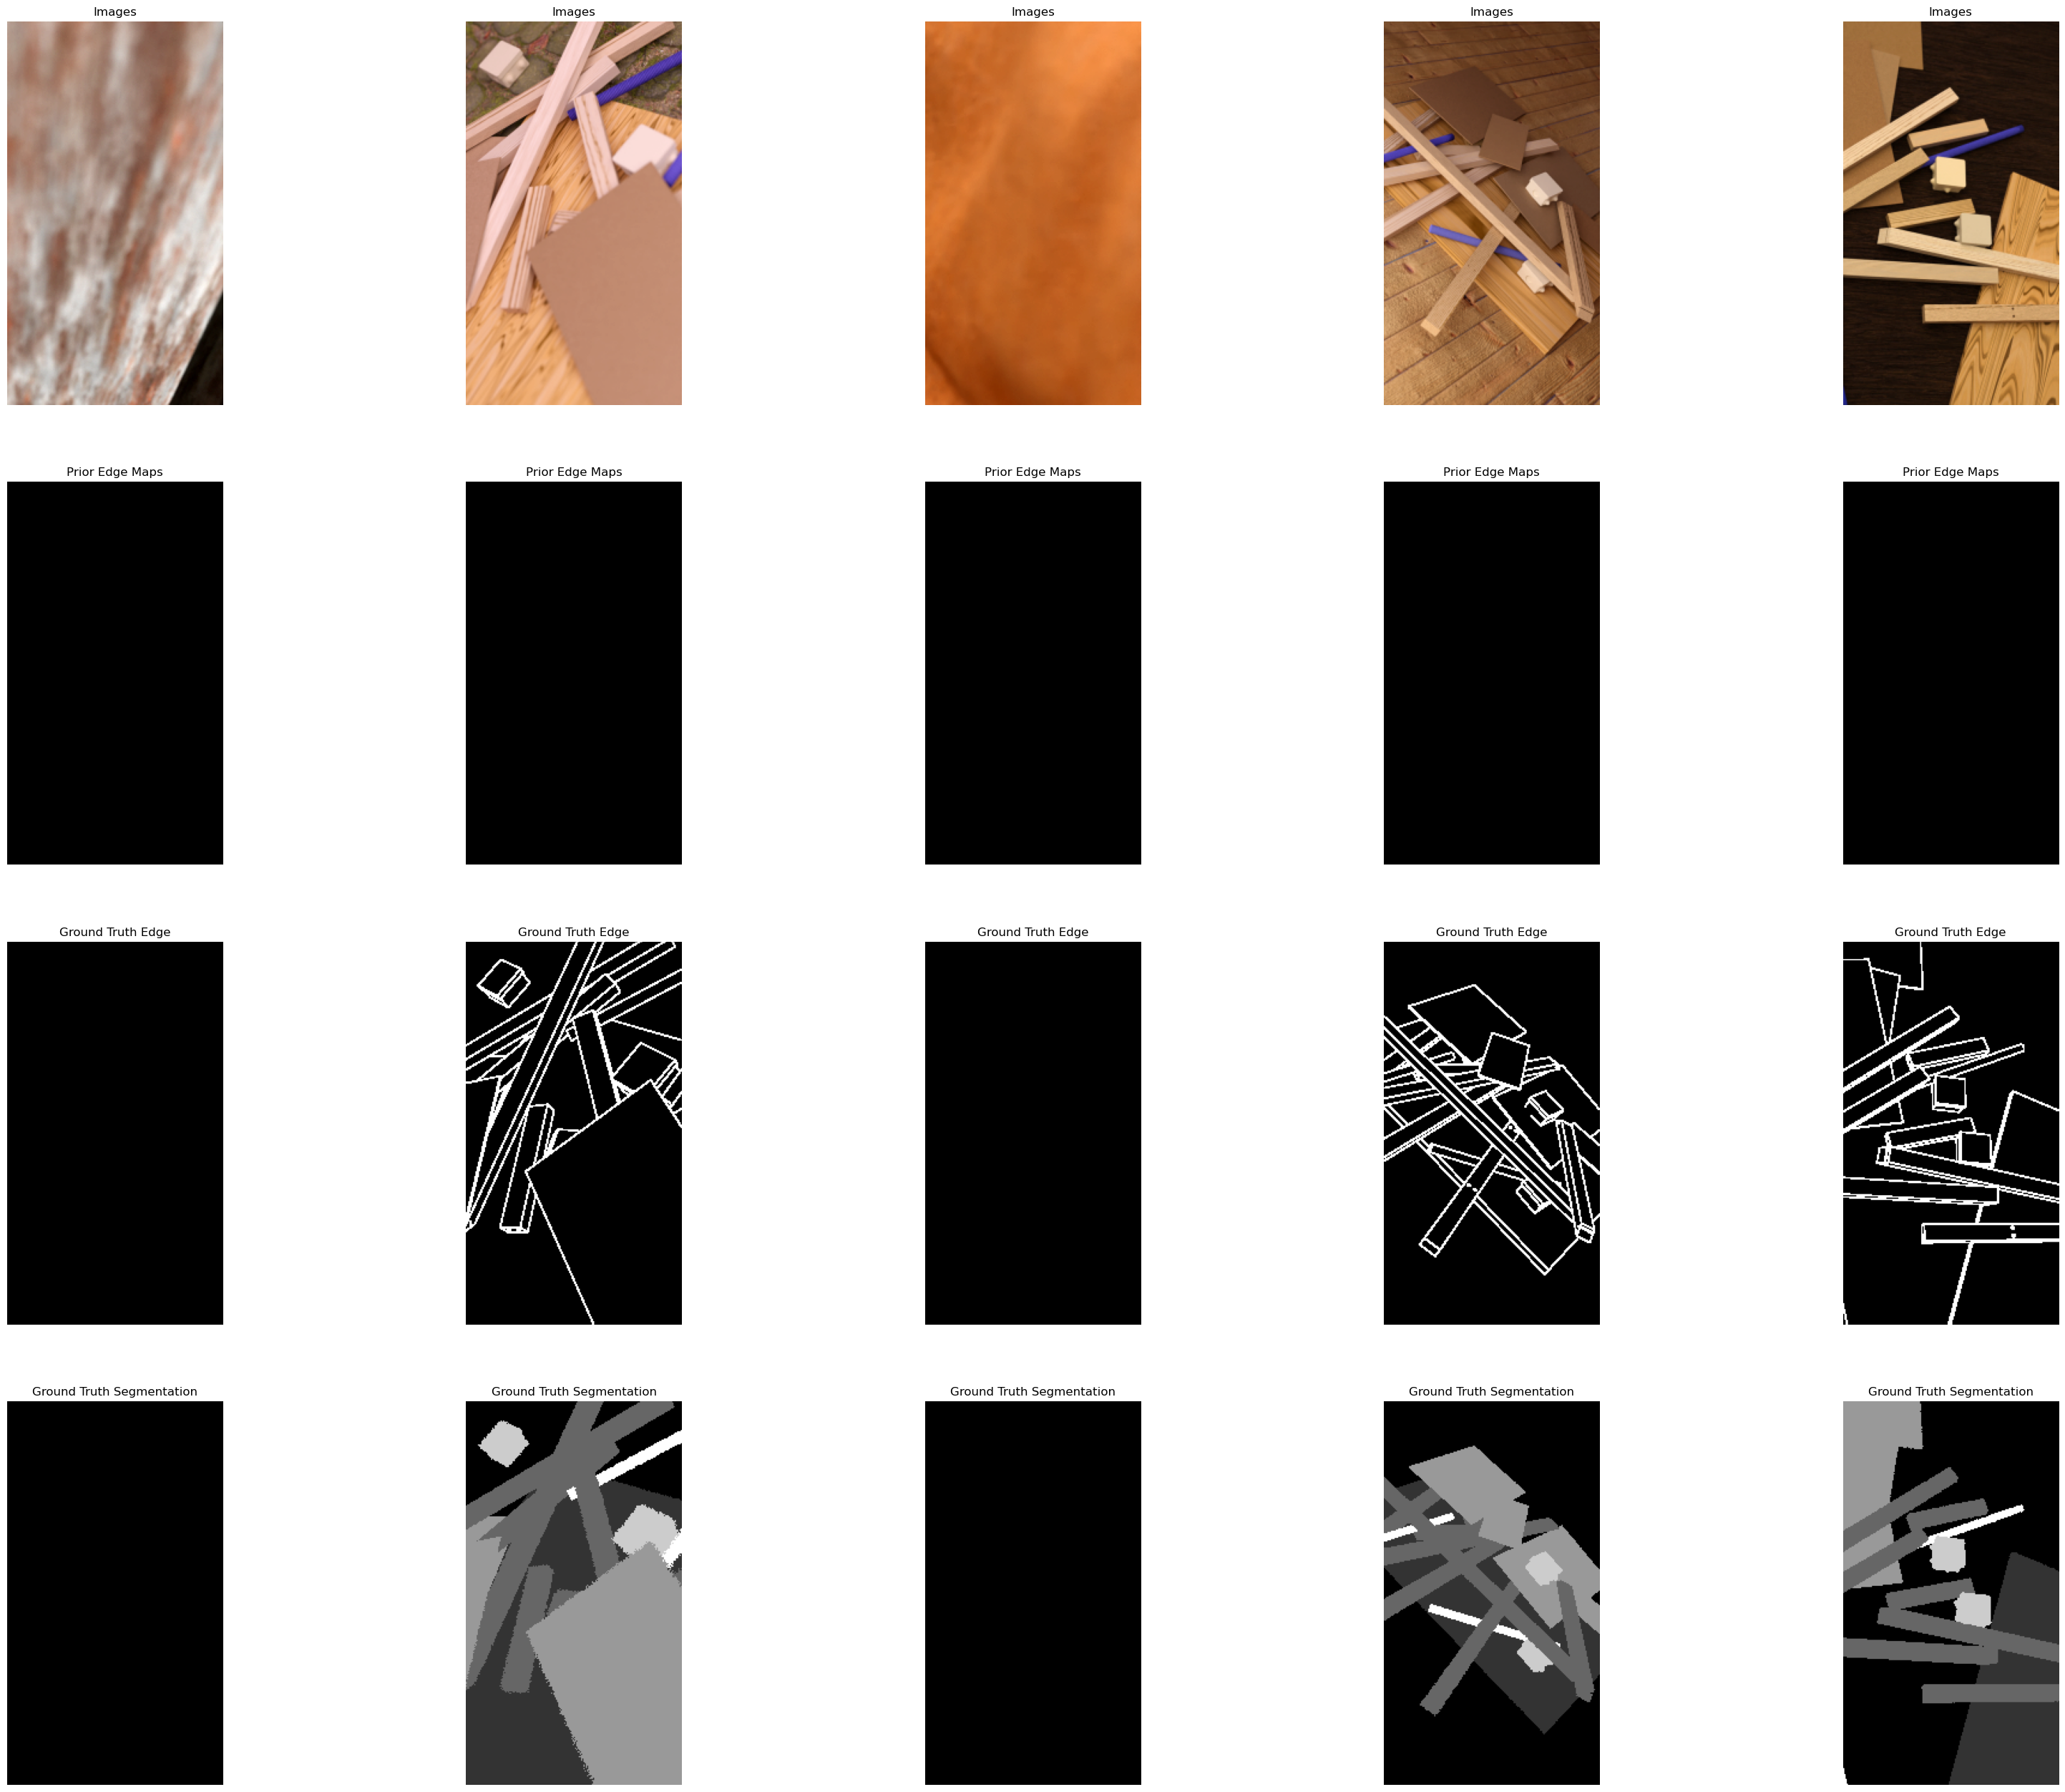

In [3]:
if Model.train_model:
    train_ds, img_count_train = DataProcessing.load_dataset(DataProcessing.key.train)
test_ds, img_count_test = DataProcessing.load_dataset(DataProcessing.key.test)

img_only_ds, img_count_img_only_ds = DataProcessing.load_dataset(DataProcessing.key.img_only)

if Model.train_model:
    for inp, out in train_ds.take(1):
        edge_detection_plots.plot_edges(images=inp['in_img'], 
                                        labels_segmentation=out['out_segmentation'],
                                        labels_edge=out['out_edge'],
                                        prior = inp['in_edge'],
                                        batch_size=DataProcessing.cfg['TEST']['BATCH_SIZE'])

# Define, Compile and Train Model

In [4]:
if Model.train_model:
    model = Model.get_neural_network_model(DataProcessing.input_data_cfg, DataProcessing.output_data_cfg)
    # model.summary()

    lr = Model.get_lr(img_count_train, DataProcessing.cfg['TRAIN']['BATCH_SIZE'])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss=Model.get_loss_function(DataProcessing.output_data_cfg),
                  metrics=Model.get_metrics(DataProcessing.output_data_cfg))

    history = model.fit(train_ds, epochs=Model.cfg["EPOCHS"], validation_data=train_ds,
                        callbacks=Model.get_callbacks(), verbose=1)

model = Model.get_best_model_from_checkpoints()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 320, 180, 10), (None, 80, 45, 10), (None, 80, 45, 1)]

In [5]:
model.summary()


tf.keras.utils.plot_model(
    model,
    to_file=Model.Data.paths['FIGURES']+"/model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_img (InputLayer)            [(None, 320, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 320, 180, 8)  224         ['in_img[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 320, 180, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

 separable_conv2d_7 (SeparableC  (None, 14, 8, 1)    101         ['batch_normalization_16[0][0]'] 
 onv2D)                                                                                           
                                                                                                  
 separable_conv2d_1 (SeparableC  (None, 40, 23, 5)   155         ['batch_normalization_9[0][0]']  
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_17 (BatchN  (None, 14, 8, 1)    4           ['separable_conv2d_7[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 40, 23, 5)   20          ['separable_conv2d_1[0][0]']     
 ormalizat

                                                                                                  
 batch_normalization_25 (BatchN  (None, 80, 45, 2)   8           ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_14 (BatchN  (None, 80, 45, 10)  40          ['separable_conv2d_4[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 concatenate_2 (Concatenate)    (None, 80, 45, 13)   0           ['batch_normalization_10[0][0]', 
                                                                  'batch_normalization_25[0][0]', 
                                                                  'batch_normalization_14[0][0]'] 
          

# Plot Results

In [5]:
if Model.train_model:
    plot_losses = ["loss", "loss"]
    plot_metrics = ["accuracy", "f1", "recall", "precision"]

    path = os.path.join(Model.Data.paths["FIGURES"], "training")

    plots.plot_training_history(history=history.history, list_of_loss_names=plot_losses,
                                list_of_metric_names=plot_metrics,
                                save=Model.cfg["SAVE"], path=path)

NameError: name 'history' is not defined

1/1 [==============================] - 0s 19ms/step


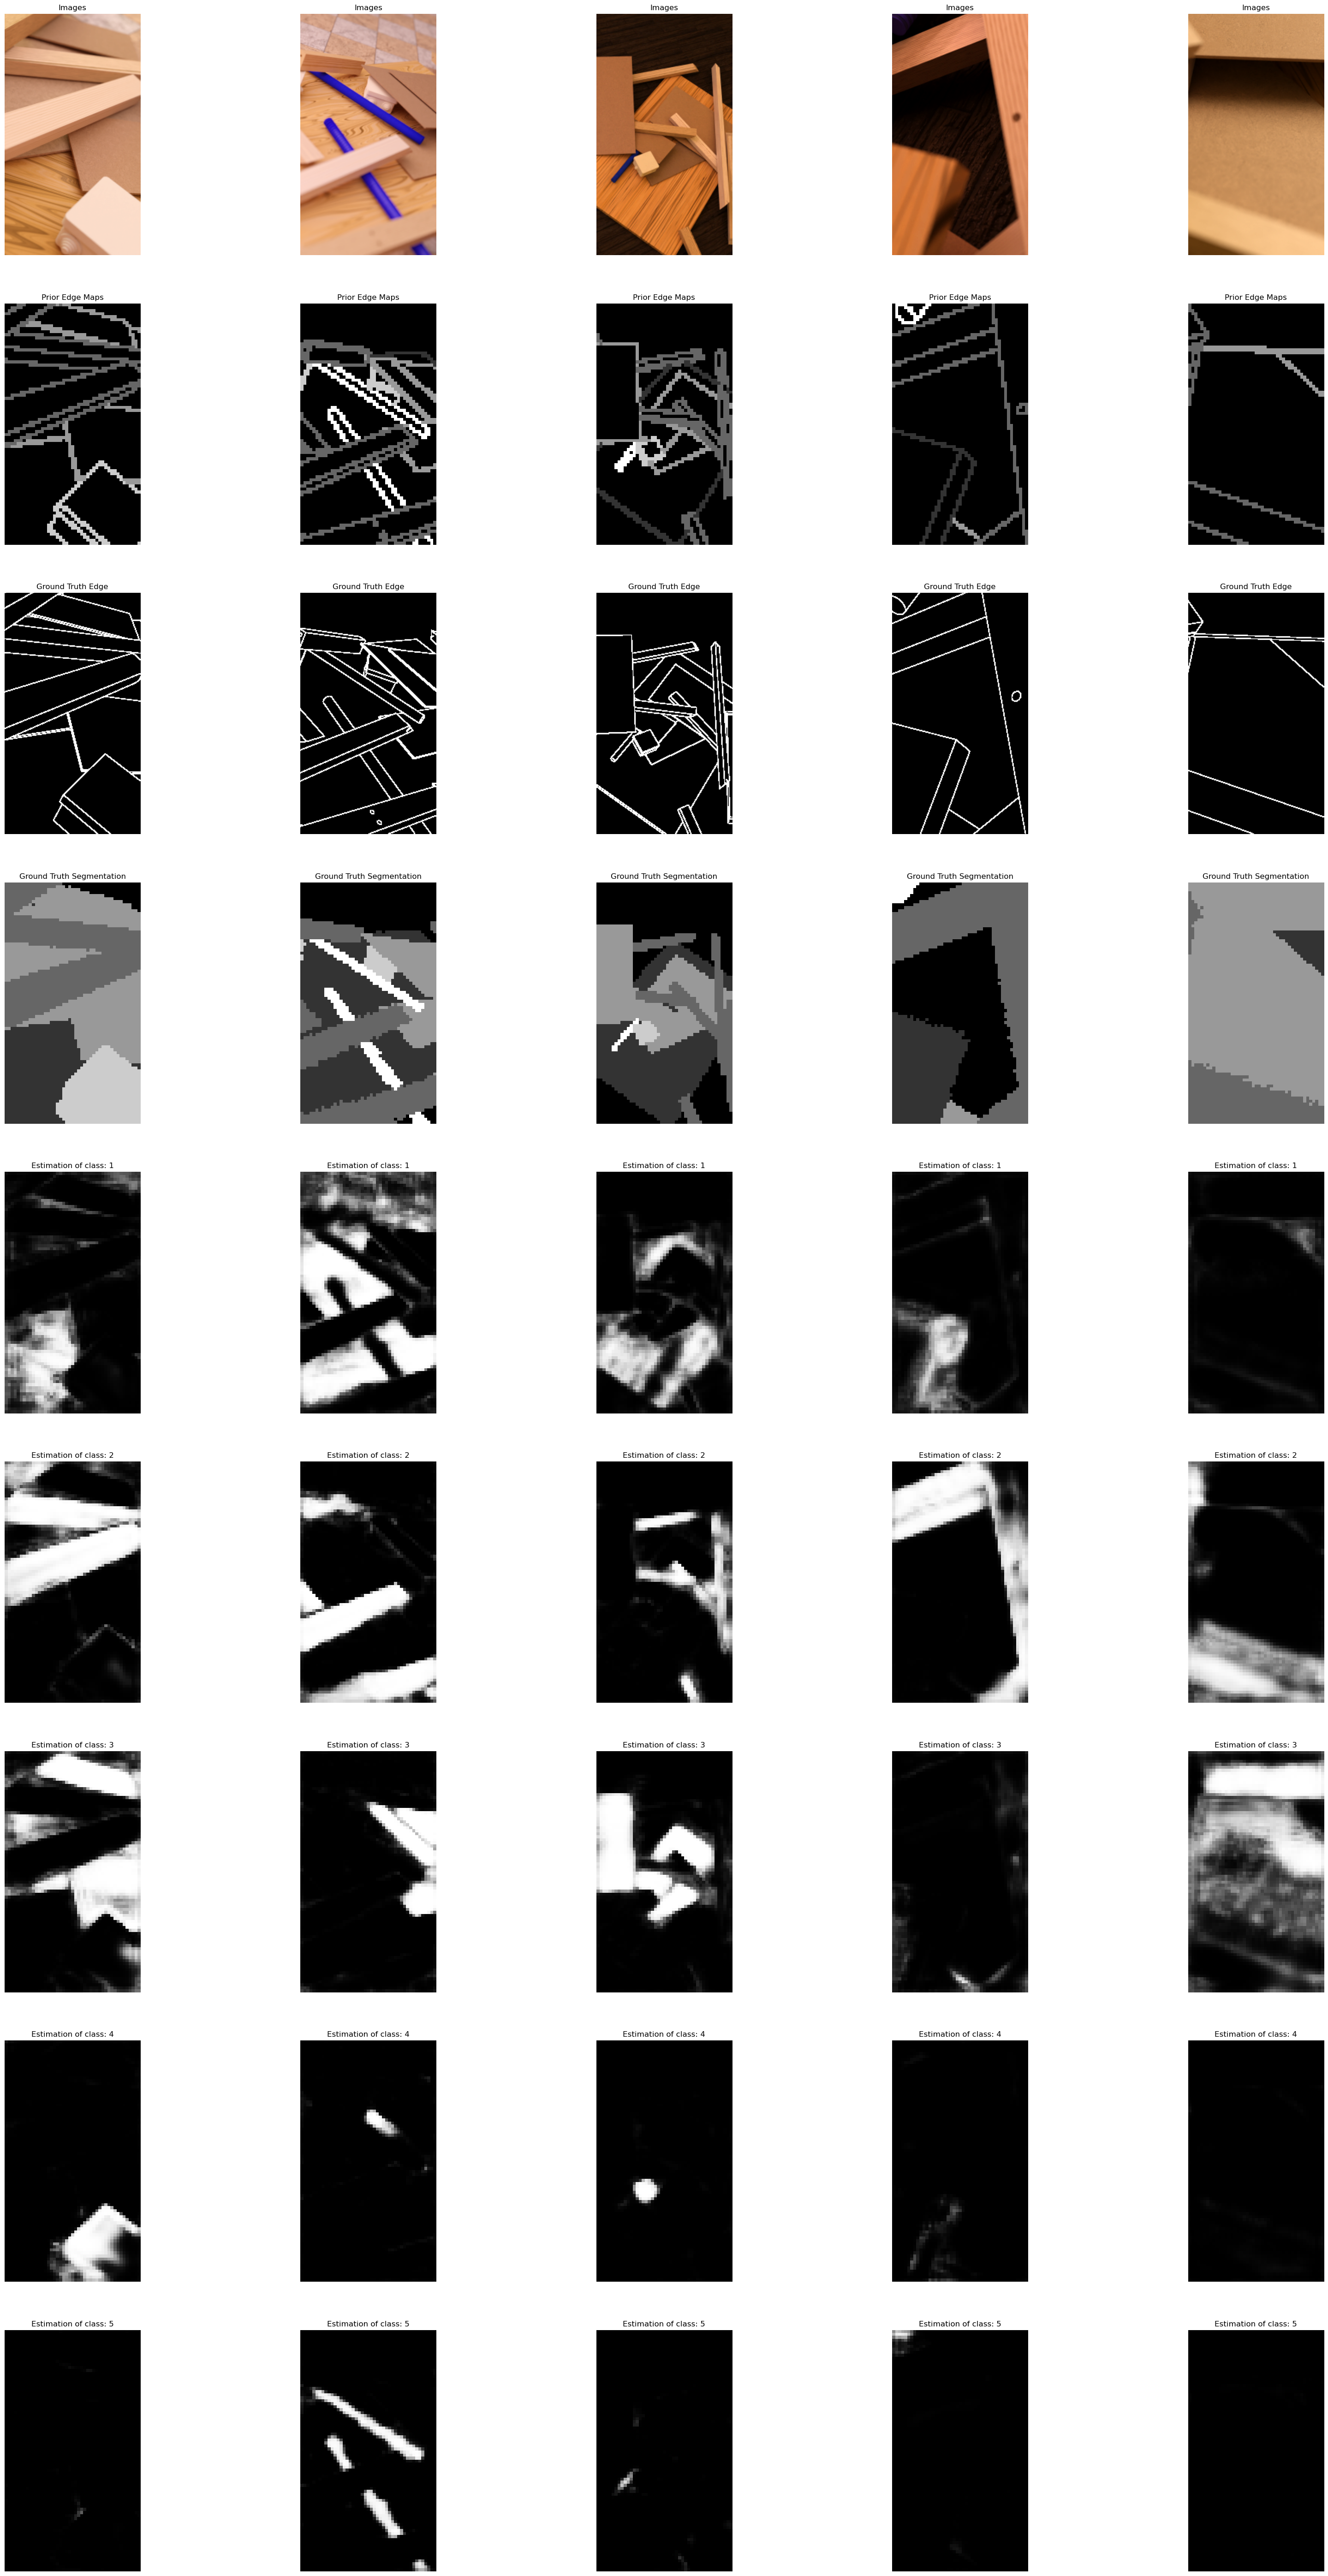

1/1 [==============================] - 0s 21ms/step


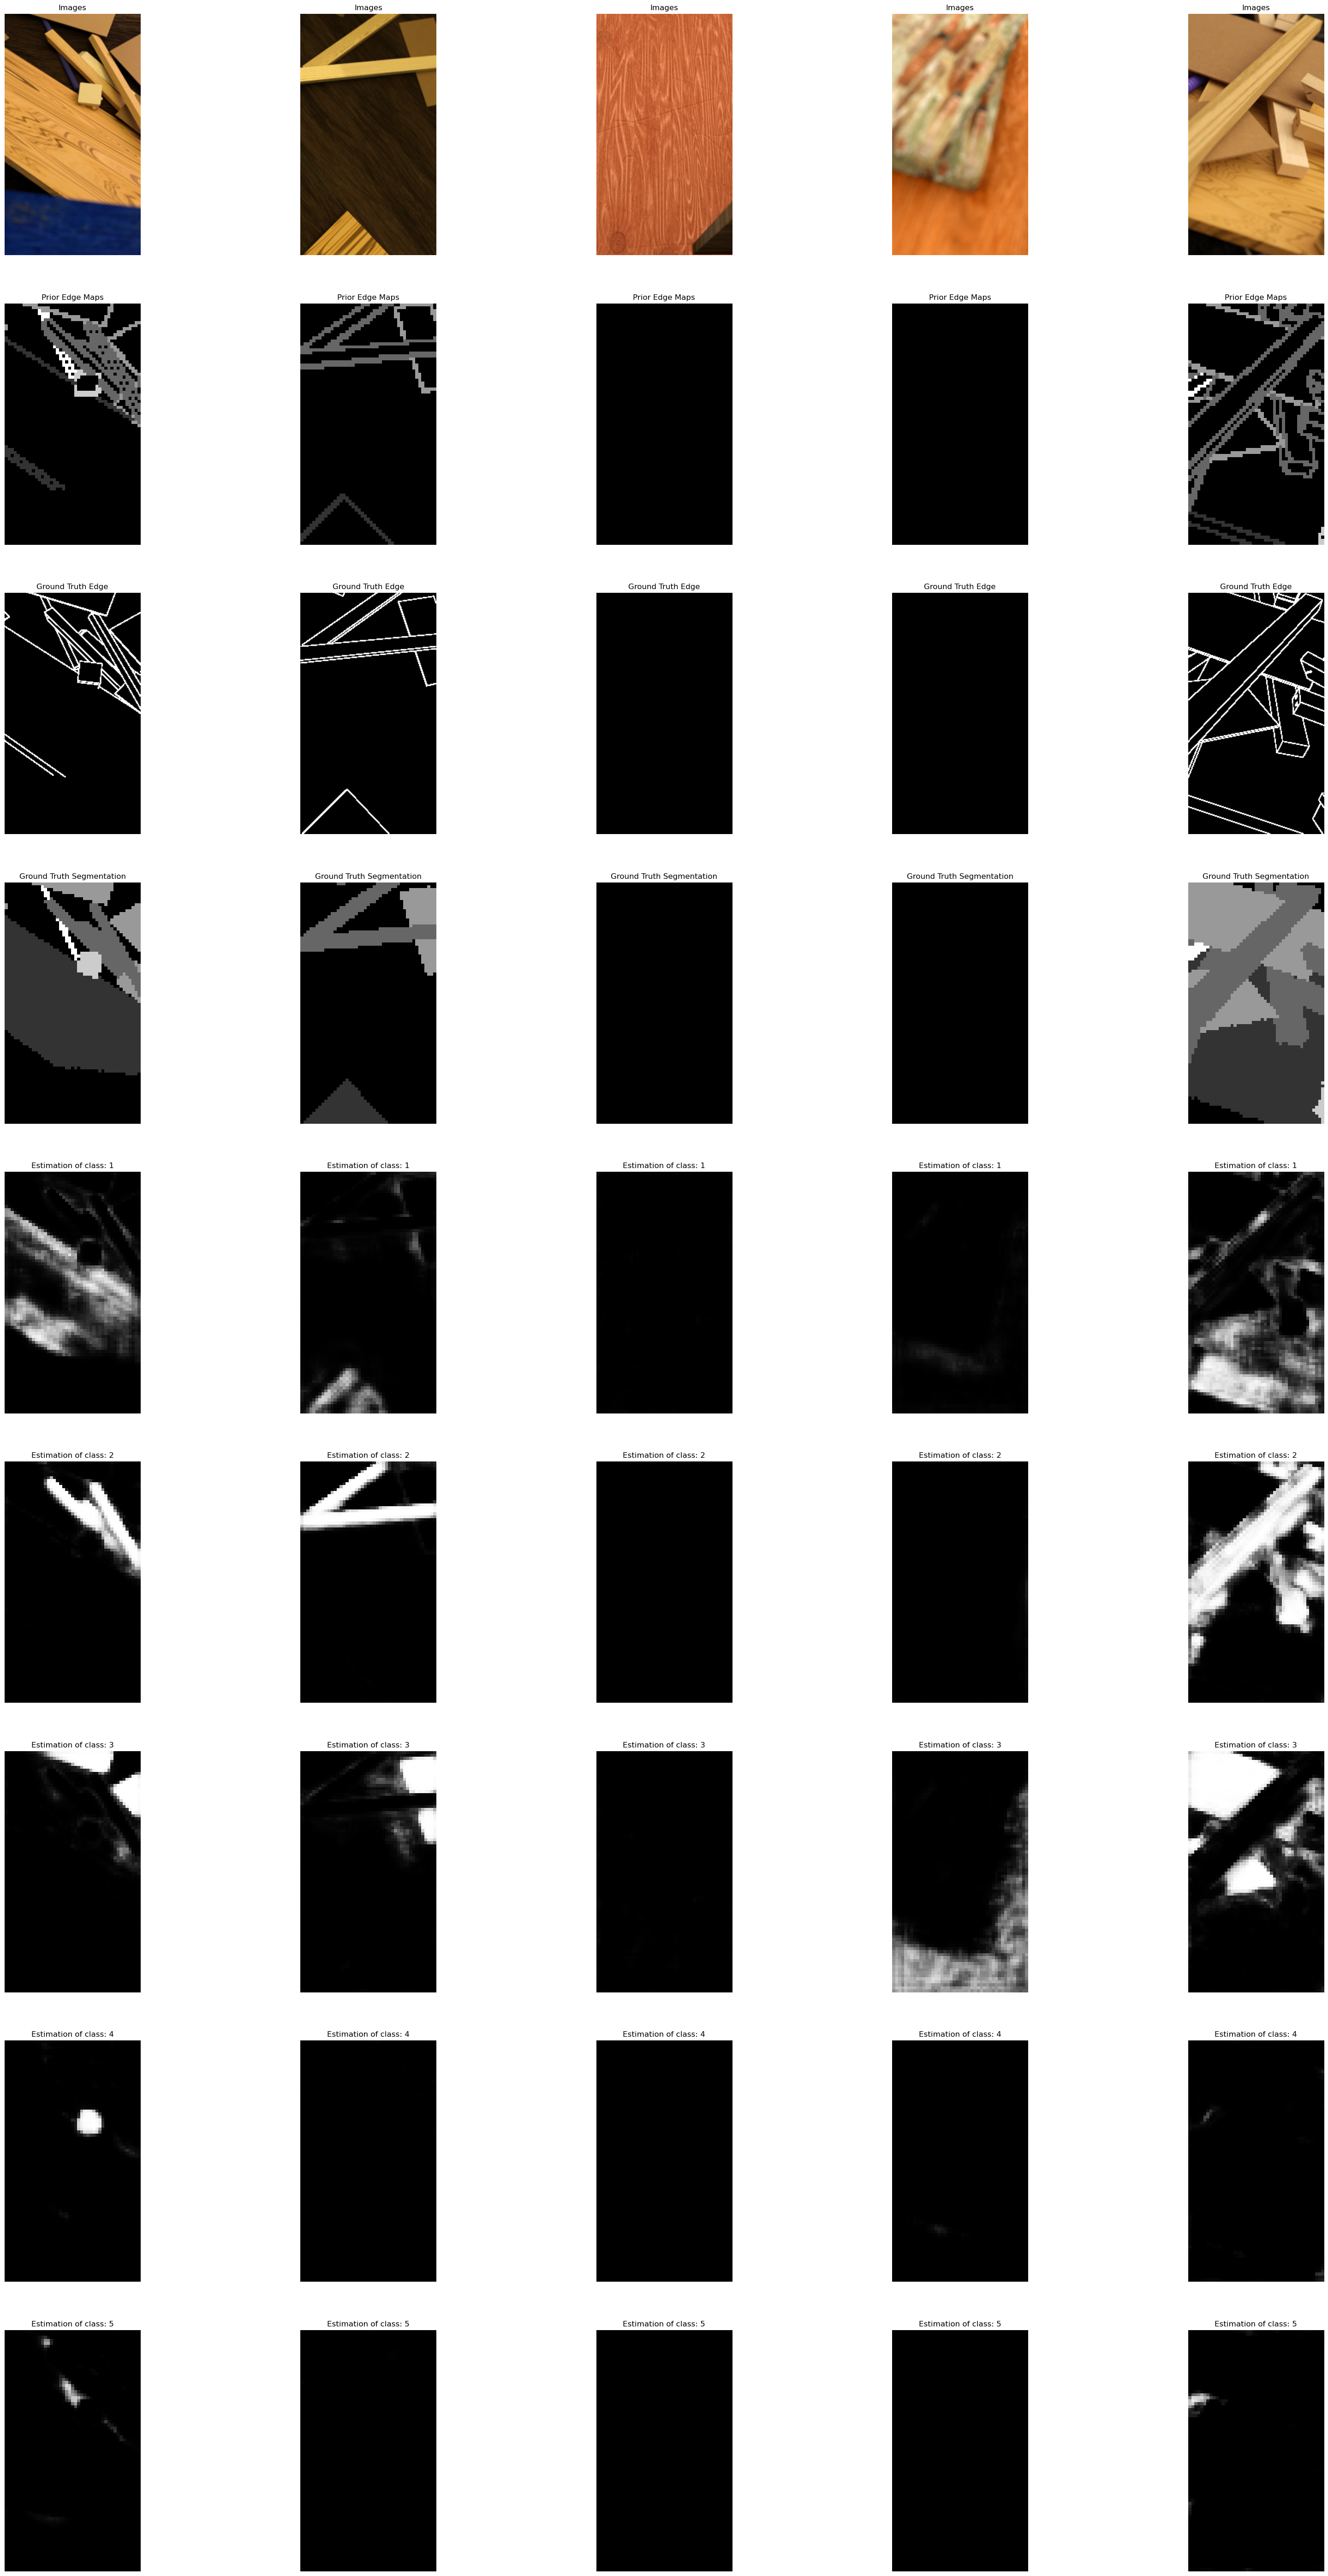

1/1 [==============================] - 0s 23ms/step


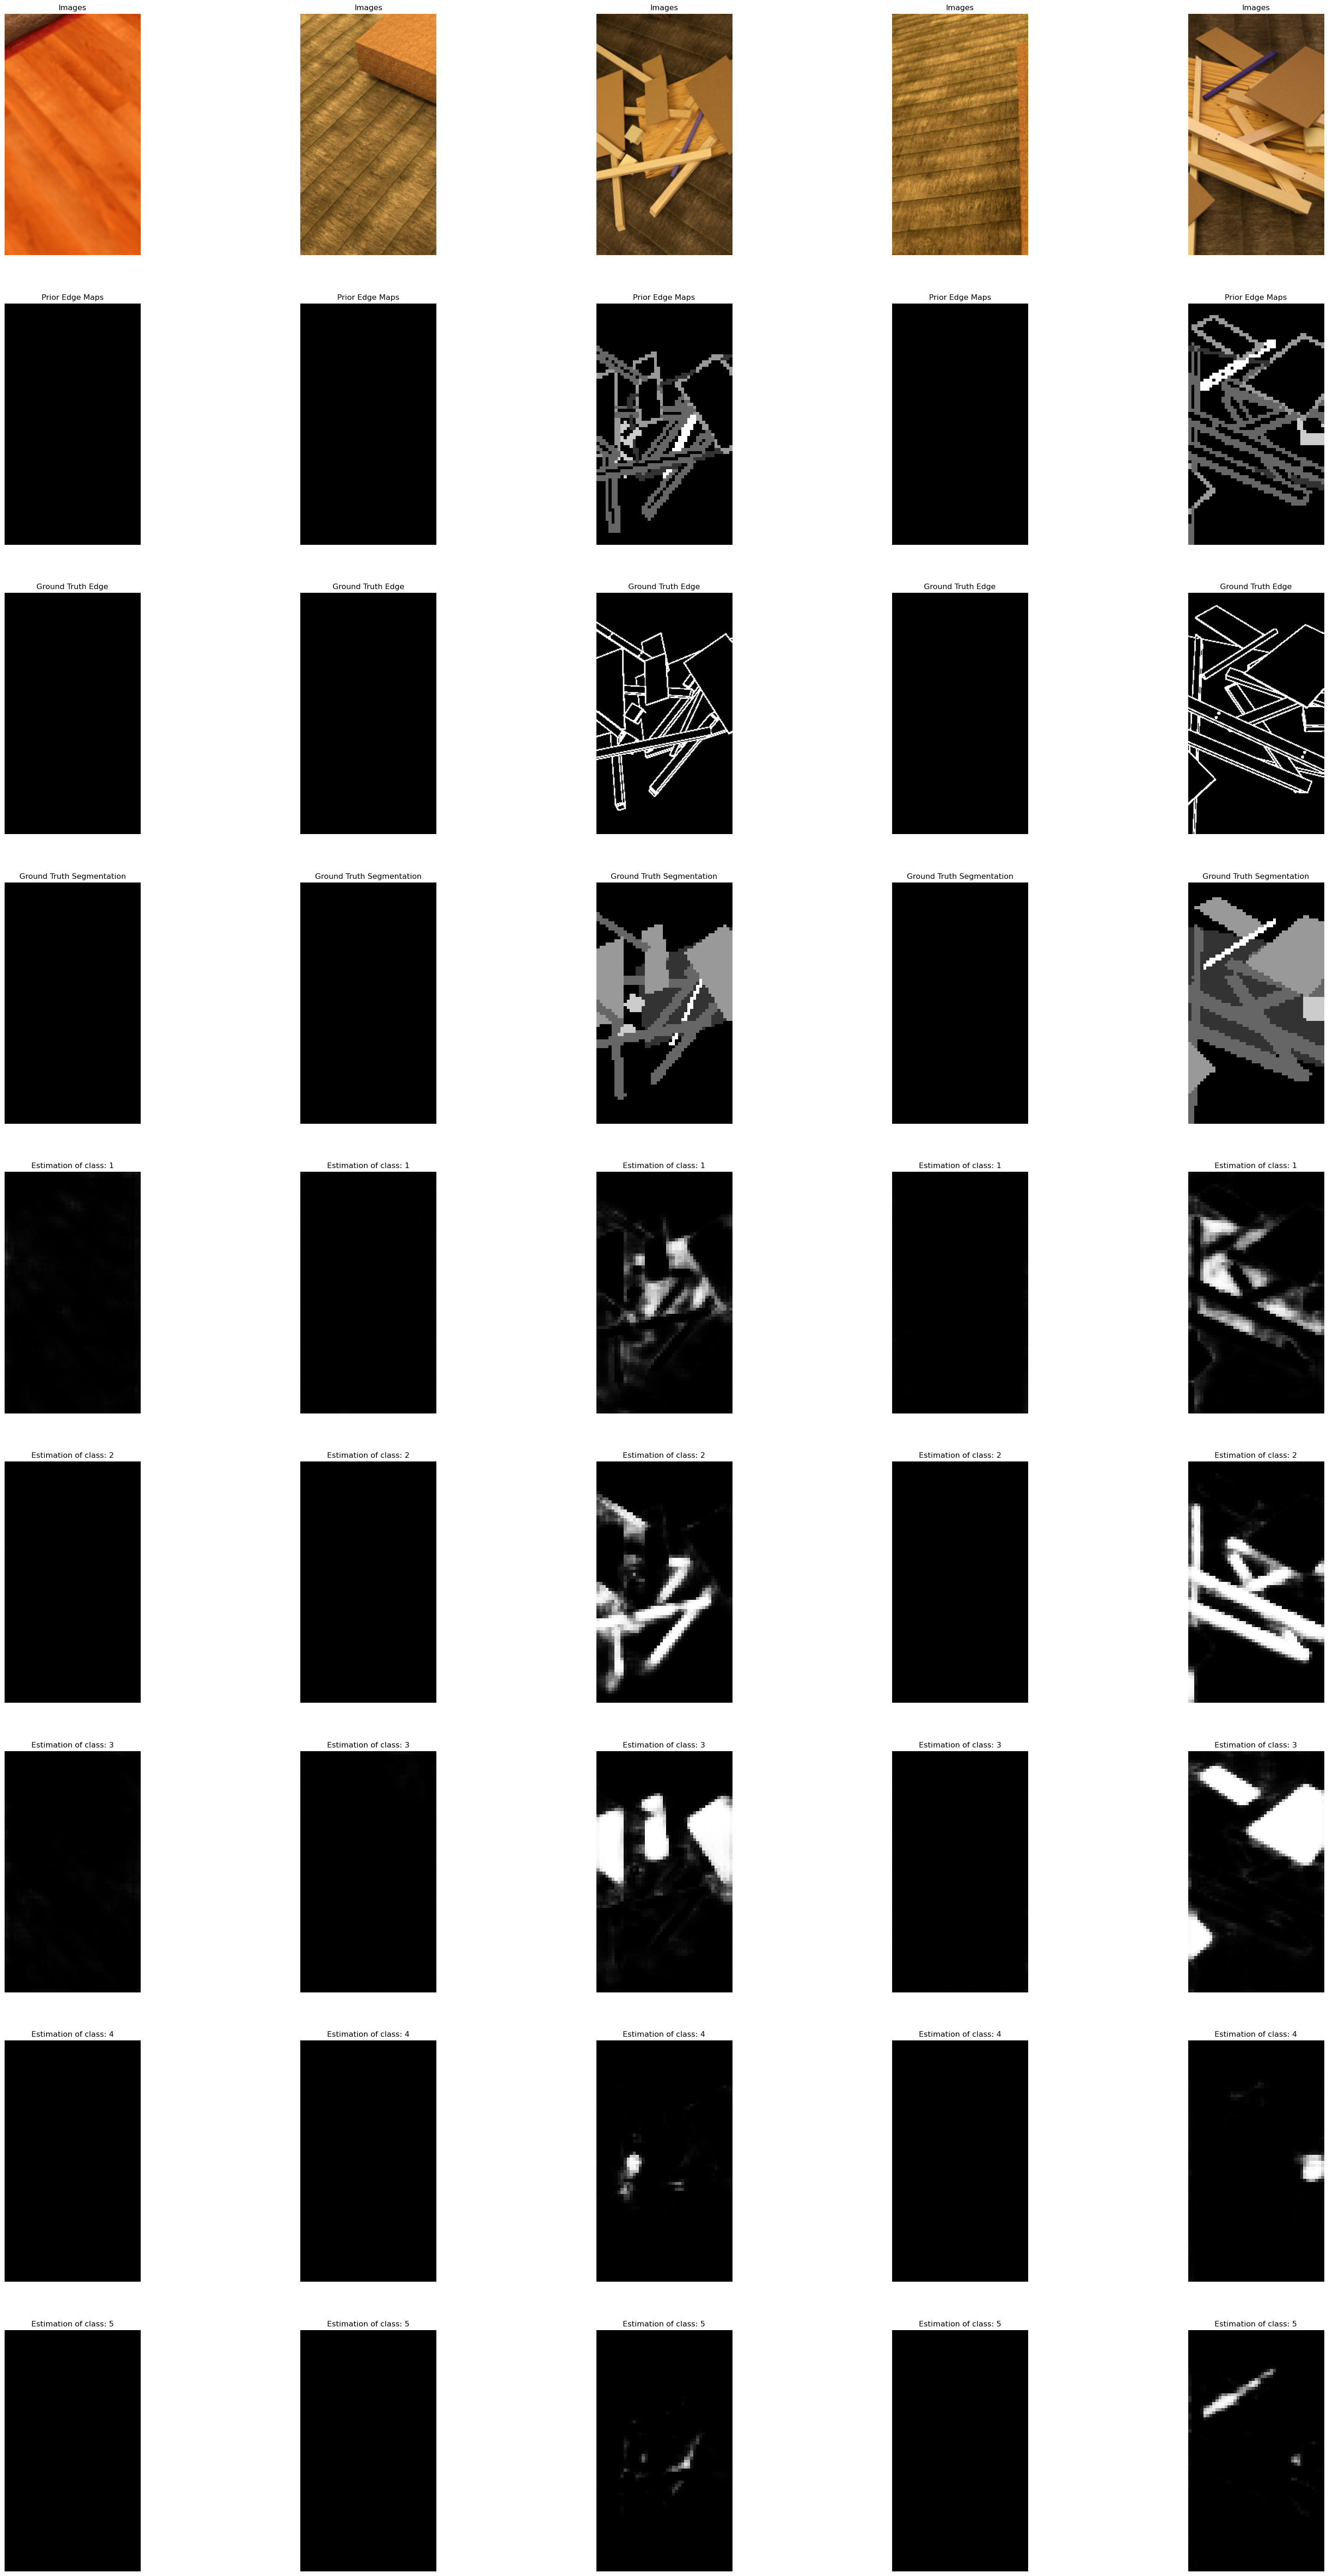

In [7]:
i = 0
for inp, out in test_ds.take(3):
    pred = model.predict(inp)
    path = os.path.join(Model.Data.paths["FIGURES"], "prediction_{}".format(i))
    edge_detection_plots.plot_edges(images=inp['in_img'],
                                    prior = inp['in_edge'],
                                    labels_segmentation=out['out_segmentation'],
                                    labels_edge=out['out_edge'],
                                    predictions=pred[1],
                                    batch_size=DataProcessing.cfg['TEST']['BATCH_SIZE'])
    i += 1

1/1 [==============================] - 0s 18ms/step


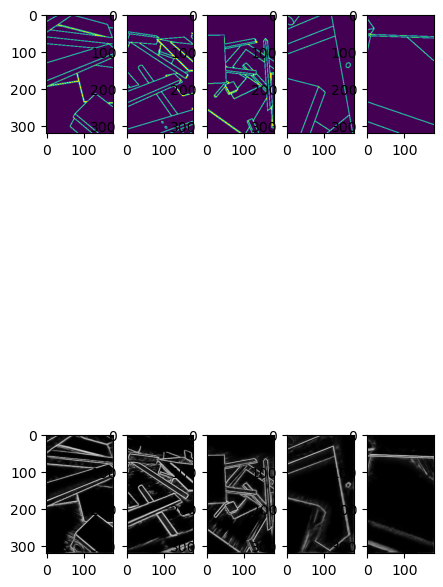

1/1 [==============================] - 0s 21ms/step


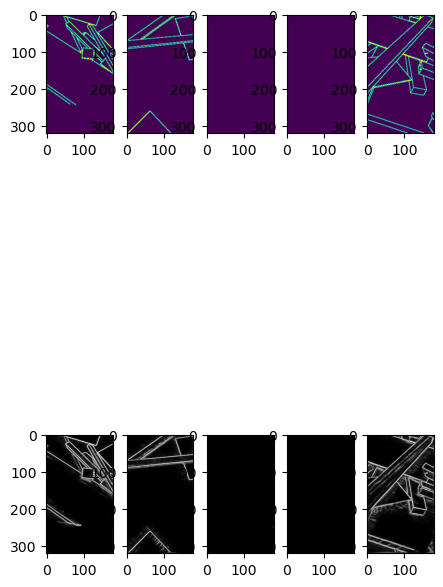

In [10]:
k = 0
output = 0 # pyramid_out
num = 1
batch = 5
for inp, out in test_ds.take(2):
    plt.figure(figsize=(5,10))
    pred = model.predict(inp)
    out_pred = pred[output]
    for i in range(batch):
        plt.subplot(num+1, batch, i + 1)
        plt.imshow((out["out_edge"][i,:,:,0]))
        for j in range(num):
            plt.subplot(num+1, batch, batch*(1+j) + i + 1)
            plt.imshow(out_pred[i,:,:,j], cmap='gray', vmin=0, vmax=1)
    path = os.path.join(Model.Data.paths["FIGURES"], "pyramid_out_{}".format(k))
    plt.savefig(path + ".svg", bbox_inches='tight')
    plt.show()
    k = k+1

In [ ]:
k = 0
output = 2 # edge_layer
num = 1
batch = 5
for inp, out in test_ds.take(2):
    plt.figure(figsize=(5,10))
    pred = model.predict(inp)
    out_pred = pred[output]
    for i in range(batch):
        plt.subplot(num+1, batch, i + 1)
        plt.imshow((out["out_edge"][i,:,:,0]))
        for j in range(num):
            plt.subplot(num+1, batch, batch*(1+j) + i + 1)
            plt.imshow(out_pred[i,:,:,j], cmap='gray', vmin=0, vmax=1)
    path = os.path.join(Model.Data.paths["FIGURES"], "side_1_{}".format(k))
    plt.savefig(path + ".svg", bbox_inches='tight')
    plt.show()
    k += 1

In [ ]:
k = 0
output = 5 # image_pyramid_in
num = 6
batch = 5
for inp, out in test_ds.take(2):
    plt.figure(figsize=(5,10))
    pred = model.predict(inp)
    out_pred = pred[output]
    for i in range(batch):
        plt.subplot(num+1, batch, i + 1)
        plt.imshow((out["out_edge"][i,:,:,0]))
        for j in range(num):
            plt.subplot(num+1, batch, batch*(1+j) + i + 1)
            plt.imshow(out_pred[i,:,:,j], cmap='gray', vmin=0, vmax=1)
    path = os.path.join(Model.Data.paths["FIGURES"], "side_2_{}".format(k))
    plt.savefig(path + ".svg", bbox_inches='tight')
    plt.show()
    k += 1

In [ ]:
### Maximum F1 Score:
path_metrics_evaluation_plot = os.path.join(Model.Data.paths["FIGURES"],
                                            "threshold_metrics_evaluation_test_ds.svg")

edge_detection_plots.plot_threshold_metrics_evaluation(model=model, ds=test_ds,
                                                       num_classes=DataProcessing
                                                       .output_data_cfg["edge"]["num_classes"],
                                                       classes_displayed_individually=True,
                                                       save=Model.cfg["SAVE"],
                                                       path=path_metrics_evaluation_plot,
                                                       accuracy_y_lim_min=0.8)


In [11]:
if Model.cfg["CONVERT_TO_TFLITE"]:
    Model.convert_model_to_tflite(model)

INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior_segmentation/TFLITE/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior_segmentation/TFLITE/assets


=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the DEQUANTIZE op takes
tensor #5 as input and produces tensor #163 as output.

Subgraph#0 main(T#0, T#1) -> [T#423, T#448]
  Op#0 DEQUANTIZE(T#5[]) -> [T#163]
  Op#1 DEQUANTIZE(T#6[]) -> [T#164]
  Op#2 DEQUANTIZE(T#7[]) -> [T#165]
  Op#3 DEQUANTIZE(T#8[]) -> [T#166]
  Op#4 DEQUANTIZE(T#9[]) -> [T#167]
  Op#5 DEQUANTIZE(T#10[]) -> [T#168]
  Op#6 DEQUANTIZE(T#11[]) -> [T#169]
  Op#7 DEQUANTIZE(T#12[]) -> [T#170]
  Op#8 DEQUANTIZE(T#13[]) -> [T#171]
  Op#9 DEQUANTIZE(T#14[]) -> [T#172]
  Op#10 DEQUANTIZE(T#15[]) -> [T#173]
  Op#11 DEQUANTIZE(T#16[]) -> [T#174]
  Op#12 DEQUANTIZE(T#17[]) -> [T#175]
  Op#13 DEQUANTIZE(T#18[]) -> [T#176]
  Op#14 DEQUANTIZE(T#19[]) -> [T#177]
  Op#15 DEQUANTIZE(T#20[]) -> [T#178]
  Op#16 DEQUANTIZE(T#21[]) -> [T#179]
  Op#17 DEQUANTIZE(T#22[]) -> [T#180]
  Op#18 DEQUANTIZE(T#23[]) -> [T#181]
  O

2022-12-28 09:35:42.114877: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-28 09:35:42.114902: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-28 09:35:42.115375: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior_segmentation/TFLITE
2022-12-28 09:35:42.129681: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-28 09:35:42.129716: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior_segmentation/TFLITE
2022-12-28 09:35:42.166683: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-12-28 09:35:42.182837: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel b